# Using queries to understand AiiDA database contents #2
## Code and calculation statistics

Time: 2 mins

In [2]:
import numpy as np
from aiida import load_dbenv, is_dbenv_loaded
if not is_dbenv_loaded():
    load_dbenv()
from aiida.orm import load_node, Node, Code, Calculation, CalculationFactory
from aiida.orm.data.structure import StructureData
from aiida.orm.data.parameter import ParameterData
from aiida.orm.calculation.job.quantumespresso.pw import PwCalculation
from aiida.orm.querybuilder import QueryBuilder
from IPython.display import Image

In [3]:
def generate_query_graph(qh, out_file_name):

    def draw_vertice_settings(idx, vertice, **kwargs):
        """
        Returns a string with all infos needed in a .dot file  to define a node of a graph.
        :param node:
        :param kwargs: Additional key-value pairs to be added to the returned string
        :return: a string
        """
        if 'calculation' in vertice['type']:
            shape = "shape=polygon,sides=4"
        elif 'code' in vertice['type']:
            shape = "shape=diamond"
        else:
            shape = "shape=ellipse"
        filters = kwargs.pop('filters', None)
        additional_string = ""
        if filters:
            additional_string += '\nFilters:'
            for k,v in filters.items():
                additional_string += "\n   {} : {}".format(k,v)


        label_string = " ('{}')".format(vertice['tag'])

        labelstring = 'label="{} {}{}"'.format(
            vertice['type'], #.split('.')[-2] or 'Node',
            label_string,
            additional_string)
        #~ return "N{} [{},{}{}];".format(idx, shape, labelstring,
        return "{} [{},{}];".format(vertice['tag'], shape, labelstring)
    nodes = {v['tag']:draw_vertice_settings(idx, v, filters=qh['filters'][v['tag']]) for idx, v in enumerate(qh['path'])}
    links = [(v['tag'], v['joining_value'], v['joining_keyword']) for v in qh['path'][1:]]

    with open('temp.dot','w') as fout:
        fout.write("digraph G {\n")
        for l in links:
            fout.write('    {} -> {} [label=" {}"];\n'.format(*l))
        for _, n_values in nodes.items():
            fout.write("    {}\n".format(n_values))

        fout.write("}\n")
    import os
    os.system('dot temp.dot -Tpng -o {}'.format(out_file_name))

#### Which codes do I have, and how many calculations have I launched with each one of them?

In [4]:
print "+-{:-^16}-+-{:-^16}-+".format("", "")
print "| {:<16} | {:^16} |".format("Codename", "#calculations")
print "+-{:-^16}-+-{:-^16}-+".format("", "")

qb = QueryBuilder()
qb.append(Code)
all_codes = qb.all()
for code, in all_codes:
    code_query = QueryBuilder()
    code_query.append(Code, filters={'id':code.id}, tag='code')
    code_query.append(Calculation, output_of='code')
    calculation_count = code_query.count()
    print "| {:<16} | {:^16} |".format(code.label, calculation_count)

print "+-{:-^16}-+-{:-^16}-+".format("", "")

+------------------+------------------+
| Codename         |  #calculations   |
+------------------+------------------+
| pw-SVN-piz-daint |       444        |
| pw-5.1           |        55        |
+------------------+------------------+


#### Visualize the last query

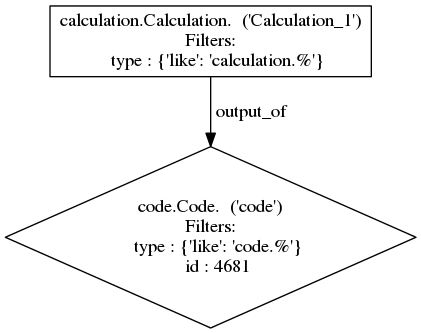

In [5]:
generate_query_graph(code_query.get_json_compatible_queryhelp(), 'query-structures-1.png')
Image(filename='query-structures-1.png')

#### Finding code statistics
I am interested in some more statistics of a specific code:
- I want to find all vc-relax QE-calculation that were run using the Code with label "pw-SVN-piz-daint" that ran on a single machine.
- What was the average walltime used by these calculations?

In [6]:
# Instantiating a query-object:
qb = QueryBuilder()
# Aadding the code and a filter on the lhttp://128.178.106.24:8888/notebooks/aiida_demos/notebook/query-structures-from-code.ipynb#abel:
qb.append(Code, filters={'label':'pw-SVN-piz-daint'}, tag='code')
# Adding the calculation as an output of this code, and a filter on the resources:
qb.append(PwCalculation, output_of='code', tag='calculation', 
          filters={'attributes.jobresource_params.num_machines':1}
    )
# Adding the parameters of the calculation to the query, filtering by calculation type:
qb.append(ParameterData, input_of='calculation',
          filters={'attributes.CONTROL.calculation':'vc-relax'})
# Adding the output-parameters of the calculation, projecting on wall time consumed:
qb.append(ParameterData, output_of='calculation', project=('attributes.wall_time_seconds'))

all_walltimes = qb.all()

print "Number of calculations:", len(all_walltimes)
print "Average walltime (in seconds):", np.mean(zip(*all_walltimes)[0])


Number of calculations: 444
Average walltime (in seconds): 550.15045045


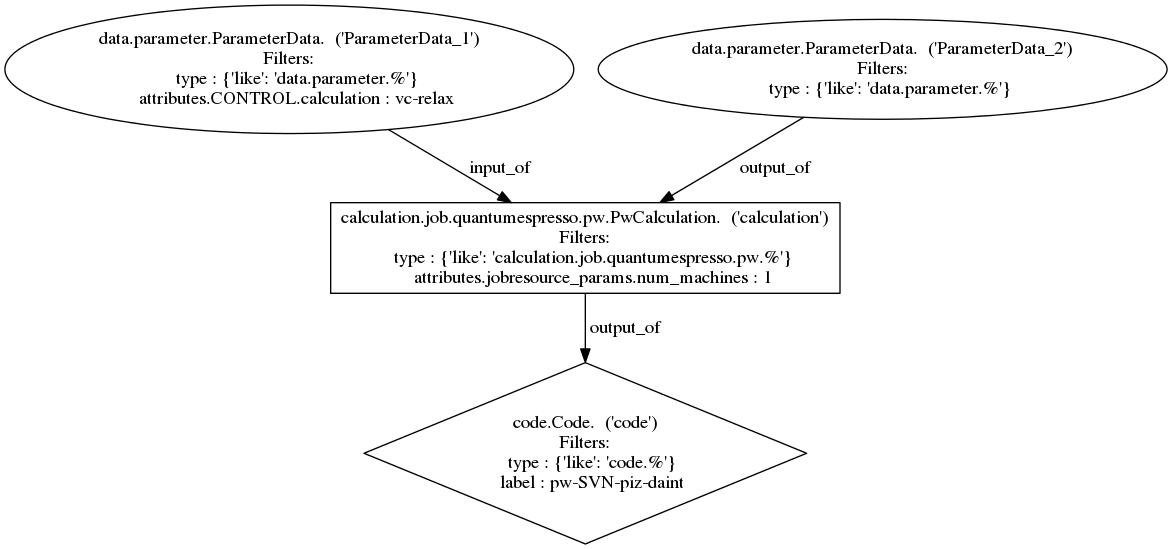

In [7]:
generate_query_graph(qb.get_json_compatible_queryhelp(), 'query-structures-1.png')
Image(filename='query-structures-1.png')